# Intro to Supervised Learning with Sci-Kit : Logistic Regression

The purpose of this code is to demonstrate the capabilities of 
sci-kit learn in the context of supervised learning. We'll
use an example built into the sci-kit learn package to explore
the available tools.

User guide: https://scikit-learn.org/stable/user_guide.html  
Toy datasets: https://scikit-learn.org/stable/datasets/toy_dataset.html  
The Breast Cancer Dataset: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

How do you install sci-kit learn?
If you are using Anaconda-Navigator and Spyder it comes already loaded.
Otherwise, you'll have to install the package using the helpful advice
from the sci-kit learn website: https://scikit-learn.org/stable/install.html

### Main Topics
- A few EDA approaches in Python
- Random forest in sci-kit and variable importance plots
- Why pipelines are so useful in sci-kit learn
- Produce an AUC/ROC plot in sci-kit learn

## Load the data

In [22]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#oftentimes, it's nice to import everything up at the top. To make it easier
#to see which packages are associated with which functions, I've imported them
#above their first use.
#%%

## I. Exploratory Data Analysis 

This dataset comes from the UC Irvine (UCI) Machine Learning Repository. Dr.William H. Wolberg's 
collected the data for research at the University of Wisconsin. He collected information
from his patients on their breast cancer since 1984. Each observation represents
a patient's original information and the followup outcome. The response variable,
whether the tumor is benign or malignant, is coded 0 and 1 respectively.




We can first call the dataset. Because this comes preloaded in sci-kit learn,
it is of type "Bunch". We can extract both X and y (see return_X_y = True)
and both as pandas dataframe with as_frame. Data are usually messy, so check
out the pre-processing tools that sci-kit offers: https://scikit-learn.org/stable/data_transforms.html

  

In [23]:
  
#%%
from sklearn.datasets import load_breast_cancer

#sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
data = load_breast_cancer(return_X_y=True, as_frame=True)
X = data[0] #extracts the data matrix
y = data[1] #extracts the response vector


#It's always a good idea to check the size of the initial dataset.
#In fact, consider printing it to csv to look at it if the dataset 
isn't too big. You'll need to change the file path on your computer to make
the write command work.You can also see the dataframe in Spyder under
Variable Explorer > Double click on the the dataframe.


In [24]:
#%%
print(X.shape)
print(y.shape)
#pd.concat([X,y],axis=1,ignore_index=False).to_csv("/Users/whit/Dropbox/UGA/MS stat grad school/Classes/zFall21/CSCI 6360 Data Science II/Workshops/Workshop 1/cancer.csv")

(569, 30)
(569,)



Now, before we investigate the dataset with sci-kit's tools, let's
split up the dataset into random training and testing datasets. We do
this so that we can evaluate the model we build on unseen data. 
As you'd expect, sci-kit learn has a handy function for doing just this.


In [25]:
#%%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])) #~0.2 is the proportion of the test set
print(y_test.shape[0]/(y_test.shape[0] + y_train.shape[0])) #~0.2 is the proportion of the test set
#%%

0.20035149384885764
0.20035149384885764


In [26]:
#EDA summary stats response
print(y_train.describe())
print(X_train.describe())

count    455.000000
mean       0.619780
std        0.485975
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64
       mean radius  mean texture  mean perimeter    mean area  \
count   455.000000    455.000000      455.000000   455.000000   
mean     14.243798     19.221934       92.803736   666.122198   
std       3.586088      4.289026       24.760323   361.017723   
min       6.981000     10.380000       43.790000   143.500000   
25%      11.725000     16.160000       75.475000   421.950000   
50%      13.480000     18.770000       87.320000   561.000000   
75%      15.935000     21.640000      104.500000   795.500000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       455.000000        455.000000      455.000000           455.000000   
mean          0.096955          0.106437        0.090533       

Here, we can look at the correlations between all variables,
including both the explanatory and response variables.

In [27]:
import seaborn as sn
corr_matrix = pd.concat([X_train,y_train],axis=1,ignore_index=False).corr()

<AxesSubplot:>

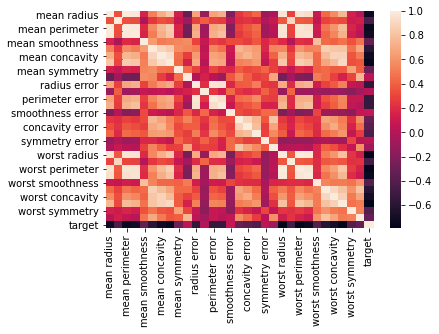

In [28]:
sn.heatmap(corr_matrix, annot=False) #no numbers

**What is the mistake in this correlation matrix?**


We notice right away that there is a lot of collinearity going
on between the different variables. So, it makes sense to look at
some sort of variable selection.


There are many techniques for variable selection, but we will go through
one based, ultimately, on PCA: each predictor explains some of the variablity
in the response, but some explain variability in a redundant way, which
we see in the correlation matrix. Imagine each variable as an n-dimensional
vector...the vectors that offer similar information should be "pointed" 
or "clustered" in similar directions. Why not identify the clusters and
select a representative variable?



But, can't you just use all the variables? For prediction purposes, you usually
actually can (see below). That being said,
even in settings where prediction is the focus, overfitting (and corresponding
lack of generality) can be a problem.



Breaking from logistic regression for a moment, let's do a quick Random Forest...
(the next two code blocks come from 
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#random-forest-feature-importance-on-breast-cancer-data)


## II. An aside - running a Random Forest

In [29]:
#%%
#to make things easier for the following functions, we'll re-import
#the dataset in a slightly different way, using the same random_state.
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [30]:
#%%
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
#%%

Accuracy on test data: 0.98


## III. Introduction to Cluster Variable Selection

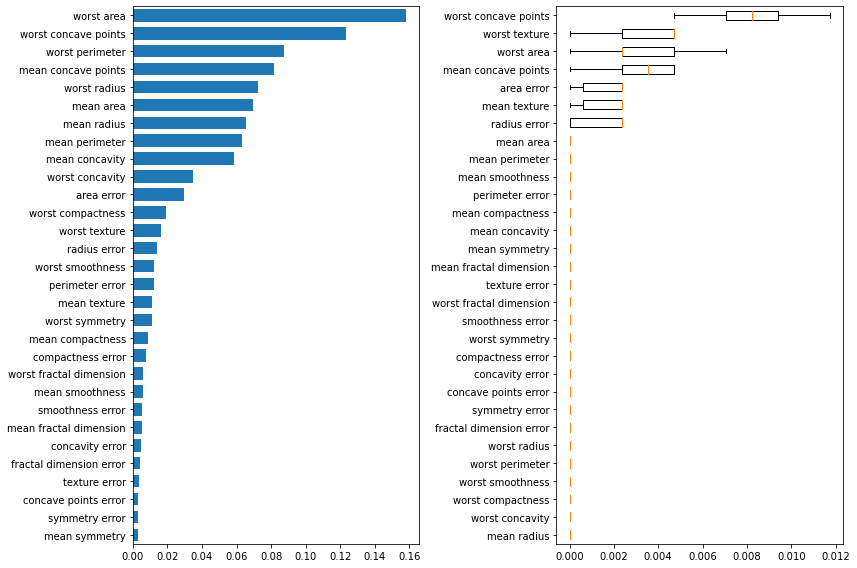

In [31]:
#%%
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()
#%%


"Next, we plot the tree based feature importance and the permutation importance. 
The permutation importance plot shows that permuting a feature drops the accuracy by at 
most 0.012, which would suggest that none of the features are important. 
This is in contradiction with the high test accuracy computed above: 
some feature must be important. The permutation importance is calculated 
on the training set to show how much the model relies on each feature 
during training." - https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#random-forest-feature-importance-on-breast-cancer-data)



Now, let's use the same websites code to untangle what is mentioned above.
How could no variables appear important when the accuracy of the random
forest model is high?


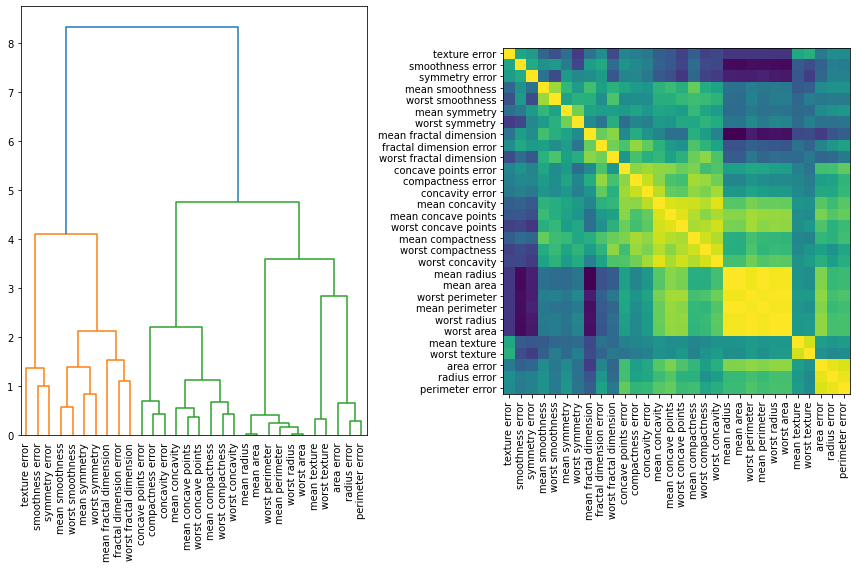

In [32]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr) #Ward's method is a way to build clusters
                                    #well suited for quantitative features
                                    #https://online.stat.psu.edu/stat505/lesson/14/14.7

dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

We don't have to worry so much about what's going on behind the scenes right now. The
important thing to know for now is that you can produce the graph on the left
which is called a dendrogram (the figure on the right is the correlation matrix
of all the variables). It's nifty because it visually shows the clusters
of features which represent vectors similarly oriented in n-dimensional space'.
In this version of variable selection, you select a representative feature
from each cluster. 

Notice the enumerate function in the loop which helps us neatly collect the count
of iterations.


In [33]:
#this code below, again comes from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#random-forest-feature-importance-on-breast-cancer-data)
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    print(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features
#%%

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


[0, 1, 4, 5, 6, 8, 9, 10, 11, 14, 15, 18, 19, 29]


This procedure selects the first feature in a cluster (compare dict_values
to selected_features to see for yourself). Now let's only select only the
selected_features from the X_train and X_test datasets.


In [34]:
#%%
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
data.feature_names[selected_features]

array(['mean radius', 'mean texture', 'mean smoothness',
       'mean compactness', 'mean concavity', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'smoothness error', 'compactness error', 'symmetry error',
       'fractal dimension error', 'worst fractal dimension'], dtype='<U23')

Now we can see how the variable selection influences the random forest.


In [35]:
clf_sel = RandomForestClassifier(n_estimators=100, random_state=10)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data using random forest with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))
#%%

Accuracy on test data using random forest with features removed: 0.98


The same accuracy is retained when we drop a bunch of features and
keep a handful. **So, the dropped variables contained redundant information**.

## IV. Logistic Regression Model: Using a Pipeline!

Let's shift gears back to the logistic regression. We can do a full logistic
regression in sci-kit learn without variable selection in only a few lines.
Sci-kit learn has this helpful approach called "pipelines" where you can
do multiple functions in series. In the language of sci-kit learn,
piplelines help you "chain pre-processors and estimators." Here,
the scaling algorithm is the pre-processor, the "estimator" is the 
logistic regression.

Here's the documentation on logistic regression with sci-kit learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression()) # apply scaling on training data
pipe.fit(X_train, y_train)
print("Accuracy on test data using logistic regression: {:.2f}".format(pipe.score(X_test, y_test)))
#this code is adapted from: https://scikit-learn.org/stable/modules/preprocessing.html

Accuracy on test data using logistic regression: 0.96



It really can be that easy. Beware though with powerful tools like sci-kit
learn! Make the statistical tool you use appropriate for the context.



We can compare the accuracy of the logistic model
using all the features and the one using just the selected ones from the
dendrogram.


In [37]:
#%%
pipe = make_pipeline(StandardScaler(), LogisticRegression()) # apply scaling on training data
pipe.fit(X_train_sel, y_train)
print("Accuracy on test data,using logistic regression and selected features: {:.2f}".format(pipe.score(X_test_sel, y_test)))
#%%

Accuracy on test data,using logistic regression and selected features: 0.96


In [38]:
pipe.predict(X_test_sel) # predicted output

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0])


Accuracy actually doesn't change when we only use selected features.
Variable selection can avoid overfitting -- we train our
model less to the ideosyncracies of the train data and more to the underlying
patterns. Such a model should generalize better.


In [39]:
pipe = make_pipeline(StandardScaler(), LogisticRegression()) # apply scaling on training data
pipe.fit(X_train_sel, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [40]:
#%%
pipe.get_params(deep=True)
#%%

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

Sci-kit learn offers some very hand tools for evaluating a model.Let's look
at what it offers for a confusion matrix and AUC/ROC plots.

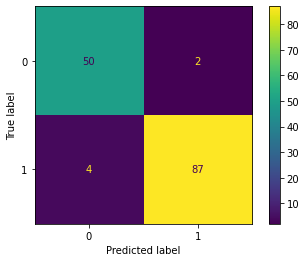

In [41]:
#%%
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_sel = pipe.predict(X_test_sel) #predictions using selected features  
cm = confusion_matrix(y_test,y_pred_sel)
cm_display = ConfusionMatrixDisplay(cm).plot()
#this code comes from https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
#with a few modifications
#%%

**Question: Which type of error (purple: bottom left or top right) is more important to minimize in this case?**


The model does a very good job of minimizing both false positives and 
false negatives. We can now look at the ROC/AUC Curve (
Receiver Operating Characteristics or Area Under the Curve) which shows
the tradeoffs between false positives and false negatives as the cutoff
in our logistic regression changes. AUC = 1: model fits perfectly.
AUC> 0.5 model is helpful. 0.5 means our model is useless (no
better than flipping a coin). Less than 0.5, model is worse than useless.

It's better than accuracy because it handles situations with skewed
distributions (example 99% of values are 1s).
https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy

Info on false positives, false negative, etc:
https://en.wikipedia.org/wiki/Sensitivity_and_specificity


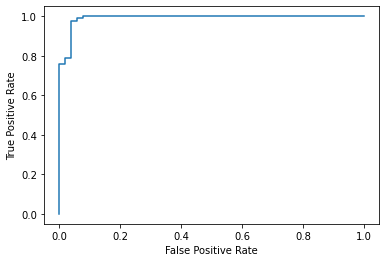

In [42]:
#%%%

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = pipe.decision_function(X_test_sel) #the numbers represent non-threshold decision values

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#code from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [43]:
#AUC/ROC value
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pipe.predict(X_test_sel)) #(true target values in test dataset, predicted target values)

0.9587912087912089

Info on the meaning of precision and recall: 
https://en.wikipedia.org/wiki/Precision_and_recall

Here's a nice summary showing how well the model does on various metrics.

In [44]:
#%%
from sklearn.metrics import classification_report
y_true = y_test
print(classification_report(y_true, y_pred_sel)) #using predictions from selected features
#%%

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        52
           1       0.98      0.96      0.97        91

    accuracy                           0.96       143
   macro avg       0.95      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143

